# Transformed outcome trees 

## Introduction

### Trees for causal inference

**The problem**

Consider the (standard) setting where you have N units, each with a pair of potential outcomes $Y_i(0)$ and $Y_i(1)$, and a treatment indicator $W_i \in {0,1}$. You observe a K-dimensional set of covariates $X_i$, and the observed outcome is $Y_i^{obs} = W_i Y_i(1) + (1-W_i)Y_i(0)$, so the data consists of the triplet $(X_i, W_i, Y_i^{obs})$ for $i = 1, \dots, N$, which are assumed to be i.i.d. draws from a large population. Assume further that observations are exchangeable and satisfy SUTVA.
$W_i$ is assumed to be unconfounded, so to be as-good-as-random conditional on $X_i$.

We are interested in obtaining accurate estimators of the conditional average treatment effect in the context of random regression trees, so estimators that are based on partitioning the covariate space and do not vary within the leaves induced by this partition.

**Random tree regression**

Random Tree models are very popular in applied machine learning for their flexibility and predictive accuracy. 
Whilst they are well-suited for predicting outcomes in high-dimensional problems, conventional regression trees are not applicable for the purposes of estimating causal quantities, such as conditional average treatment effects, since one does not observe unit-level causal effects ("the fundamental problem of causal inference").

In their PNAS paper, Athey and Imbens (2016) propose a method for estimating causal effects using random forests, via a new method for constructing the model structure, that can be viewed as a modification of the standard CART algorithm. The appeal of the idea is to combine the machine learning approach of random trees to estimation with the ability to estimate causal quantities.

Essentially, the key of the idea is to propose an analagous MSE splitting criterion for generating splits in the covariate space that will allow to "grow" a tree that allows the comparison of "similar" treated and untreated units in its leaf nodes.

In the conventional CART algorithm, splits are chosen to miminize the mean squared loss (MSE) of the outcome variable.
Here however we are not interested in the outcome $Y_i^{obs}$, but in the CATE:
$$
\tau(x;\Pi) = \mathbb{E}[Y(1) - Y(0) | X = x] = \mu(1,x;\Pi) - \mu(0,x;\Pi)
$$
where $\Pi$ is the partition of the covariate space induced by the tree, and $\mu(w,x,\Pi)$ is the mean outcome of observations with status $w_i$ in a leaf, given by 
$$
\mu(w,x;\Pi) = \mathbb{E}[Y_i(w), X_i \in l(x;\Pi)) \: \text{where } l(x;\Pi) \text{ is the leaf containing } x
$$

The estimated counterpart $\hat{\mu}(w,x,S,\Pi)$ for $\mu(w,x,\Pi)$ is simply given by the average outcome of observations in sample S with $W = w$ in the leaf $l(x;\Pi)$, and the estimated conditional average treatment effect accordingly by:
$$
\hat{\tau}(x;S,\Pi) = \hat{\mu}(1,x,S,\Pi) - \hat{\mu}(0,x,S,\Pi)
$$

In CART fashion, when trying to construct a tree for causal inference, one would ideally like to split the data in a way that minimizes the MSE of the treatment effect:

$$
MSE_{\tau}(S^{te}, S^{est}, \Pi) = \frac{1}{\#(S^{te})} \sum_{i \in S^{te}} \left (\tau_i - \hat{\tau}(X_i; S^{est}, \Pi)^2 - \tau^2_i \right )
$$
where $S^{te}$ is the test set , $S^{est}$ is the estimation set. ***The corresponding splitting criterion now is just the expection over the estimation and test samples.***
The subtraction of $\tau^2_i$ is without loss as it does not affect how the criterion ranks different estimators and is used to allow for a an algebraic expansion in later derivations.

However, this is of course infeasible, since $\tau_i$ is not observed!

**Solution**

The authors show that the this expected-MSE criterion has an unbiased estimator that can be computedd from the data using only $S^{tr}$ and knowlege of $N^{est}$, and can hence be used to construct a tree for conditional causal effects analogously to the standard CART algorithm. 

Intuitively, the criterion rewards partitions for finding strong heterogeneity in the treatment effect.

**A simpler method**

There is existing software to "grow" random trees (and forests) according to this design, which is been taken up with great enthusiasm in the applied literature.

For the sake of exposition, there is however a simpler method that allows off-the-shelf machine learning packages featuring standard implementations of CART to be used for the same purpose of finding CATEs.

The idea is based on a single transformation of the outcome, the so-called Horvitz-Thompson transformation.
For a randomly assigned treatment $W_i$, with $Pr(W_i = 1) = p$, define the transformed outcome $Y_i^*$ as:
$$
Y_i^* = Y_i \frac{W_i - p}{p(1-p)}
$$

The nice thing about this trick is that we have:

$$
\mathbb{E}[Y_i^* | X_i = x_i] = \tau(x_i)
$$

so training a standard off-the-shelf CART tree to predict $Y_i^*$ will give us an estimate of the CATE.

The drawback here is that this approach is not efficient at all. It does not use the information on the assignment beyond construction of the transformed outcome: The sample average in a given leaf will only be equal to $\hat{\tau}(x_i)$ if the fraction of treated observations hapens to actually be exactly equal to $p$ - which is only true in expectation. 


### A note on **honest** estimation

Athey & Wager propose the term "honest" estimation for the procedure of selecting a model structure (i.e. the partition $\Pi$ of the covariate space in the context of a random tree) if it does not use the same information that is used for estimation, given the model structure.

This is accomplished by splitting the training set, that is assumed to consist of iid samples, into two parts: a set for construction of the tree (including cross-validation for pruning) and a set for estimation of the estimand of interest within each leave of the tree (for causal trees, this will be the treatment effect).

The benefit of this approach is that independence guarantees that asymptotic properties of the estimates are the same as if the model structure (partition) had been exogenously given, and hence allows to do inference on the estimated treatment effects for different subgroups. The cost is that the estimation procedure is less efficient, since the estimation set is smaller than the full training set.

## Demonstration

### Heterogeneous treatment effects as done in Athey & Imbens 2016 (PNAS)

We now move to the level of causal complexity we are interested in: we have a model $\eta(x)$ for the mean effect and a model $\kappa(x)$ for the treatment effect. Here I replicate the first of the three settings from the paper.

I first replicate their data simulation with independent Xs (as they do), and then move to correlated Xs. Recall that the behaviour of SHAP values will depend on correlations of covariates...

**Setting**
- K = 2
- $\eta(x) = \frac{1}{2}x_1 + x_2$
- $\kappa(x) = \frac{1}{2}x_1$
- w fully randomized

**Data generating process**
- $Y_i(w) = \eta(X_i) + \frac{1}{2}(2w-1) \kappa(X_i) + \epsilon_i(w)$

where $\epsilon_i(w) \sim N(0,0.01)$ and the Xs are independent $X_i \sim N(0,1)$.

**Summary**

Thus, we can write the DGP as follows:
$$Y_i(w) = \frac{1}{2}x_1 + x_2 + \frac{1}{2}(2w-1) \frac{1}{2}x_1 + \epsilon_i(w)$$

Just for completeness, the CATE is then of course given by:
$$\tau(x) = E(Y_i(1) - Y_i(0) | X) = E(Y_i | X, W=1) - E(Y_i | X, W=0) = \frac{1}{2}\kappa(X_i) - -\frac{1}{2}\kappa(X_i) = \kappa(X_i) = \frac{1}{2}x_1$$

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set seed
np.random.seed(123)

# simulating data

def simulate_exp1(n, pr_w = 0.5, var_eps = 0.01):
    # draw both Xs from independent normals
    x1 = np.random.normal(0, 1, n)
    x2 = np.random.normal(0, 1, n)
    # compute random w
    w = np.random.binomial(1, pr_w, n)
    # compute error
    epsilon = np.random.normal(0, var_eps, n)
    # compute outcome
    y = 0.5 * x1 + x2 + 0.5*((2*w)-1)*0.5*x1 + epsilon
    # compute transformed outcome for TOT
    y_transformed = (y*(w-pr_w)) / (pr_w*(1-pr_w))
    # we also compute the true CATE for each observation
    cate = 0.5*x1
    # create dataframe
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'w': w, 'y': y, 'y_transformed': y_transformed, 'cate': cate})
    return df

# simulate data
df = simulate_exp1(3000, pr_w=0.5, var_eps=0.01) # as in paper
df.head()

,x1,x2,w,y,y_transformed,cate
0,-1.085631,-0.450599,0,-0.729864,1.459728,-0.542815
1,0.997345,0.609590,1,1.353023,2.706046,0.498673
2,0.282978,1.173744,1,1.393182,2.786364,0.141489
3,-1.506295,0.871815,0,0.501540,-1.003081,-0.753147
4,-0.578600,1.904723,1,1.463416,2.926832,-0.289300


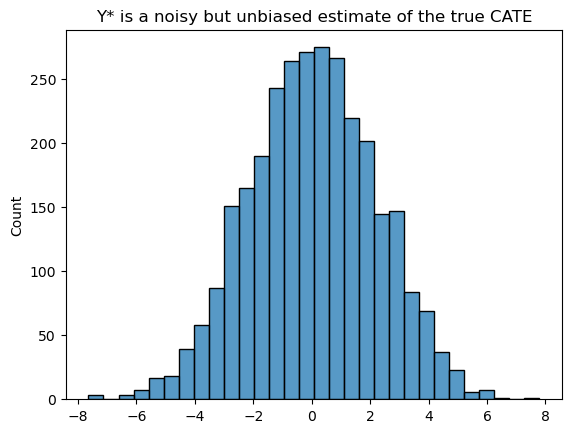

In [5]:
# plot difference between y_transformed and cate
cate_diff = df['y_transformed'] - df['cate']
sns.histplot(cate_diff, bins=30)
plt.title('Y* is a noisy but unbiased estimate of the true CATE')
plt.show()

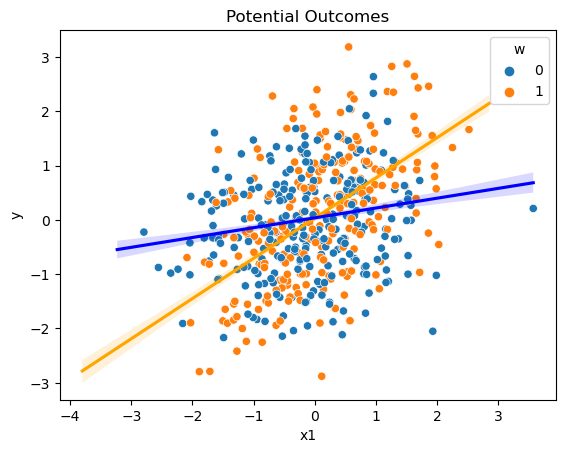

In [6]:
# plot potential outcomes across x1
sns.scatterplot(x='x1', y='y', hue='w', data=df.sample(500))
plt.title('Potential Outcomes')
# add regression line for both groups
sns.regplot(x='x1', y='y', data=df[df['w']==1], scatter=False, color='orange')
sns.regplot(x='x1', y='y', data=df[df['w']==0], scatter=False, color='blue')
plt.show()

We now apply the transformation:

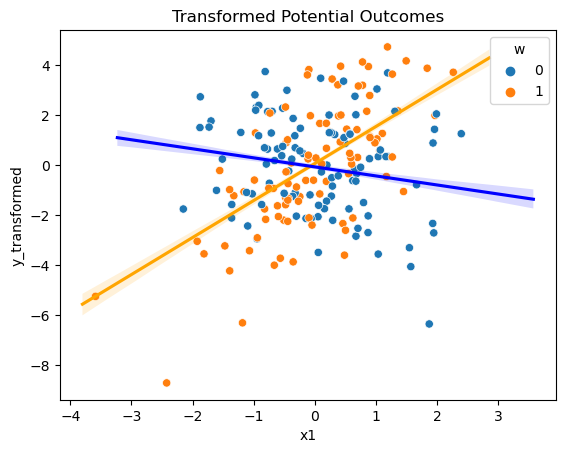

In [7]:
# plot transformed potential outcomes across x1
sns.scatterplot(x='x1', y='y_transformed', hue='w', data=df.sample(200))
plt.title('Transformed Potential Outcomes')
# add regression line for both groups
sns.regplot(x='x1', y='y_transformed', data=df[df['w']==1], scatter=False, color='orange')
sns.regplot(x='x1', y='y_transformed', data=df[df['w']==0], scatter=False, color='blue')
plt.show()

### Fitting a Transformed outcome tree (TOT)

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# auxiliary functions to train adaptive and honest TOTrees

def train_tree_H(data, **kwargs):
    # get random sample split for training and estimation for honest approach (like in the paper, 50% train, 50% estimation)
    train_mask = np.random.binomial(1, 0.5, data.shape[0])
    # get train and estimation sample
    train = data[train_mask==1]
    estimate = data[train_mask==0]

    # CV grid
    grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

    # fit honest tree
    rf_cv_adaptive = GridSearchCV(DecisionTreeRegressor(**kwargs), grid, cv=5)
    rf_cv_adaptive.fit(train[['x1', 'x2']], train['y_transformed'])
    # get params of best tree
    best_tree_adaptive = rf_cv_adaptive.best_estimator_
    print(rf_cv_adaptive.best_params_)

    # add predictions to dataframe for rows in estimation set
    data.loc[train_mask==0, 'y_transformed_pred_honest'] = best_tree_adaptive.predict(estimate[['x1', 'x2']])

    return best_tree_adaptive

def train_tree_A(data, **kwargs):
    # fit adaptive tree
    grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
    rf_cv_honest = GridSearchCV(DecisionTreeRegressor(**kwargs), grid, cv=5)
    rf_cv_honest.fit(data[['x1', 'x2']], data['y_transformed'])
    # get params of best tree
    best_tree_honest = rf_cv_honest.best_estimator_
    print(rf_cv_honest.best_params_)

    # predict using estimation set
    data['y_transformed_pred_adaptive'] = best_tree_honest.predict(data[['x1', 'x2']])

    return best_tree_honest



Training an honest and an adaptive tree:

In [11]:
A_tree = train_tree_A(df, min_samples_leaf=4)
H_tree = train_tree_H(df, min_samples_leaf=4)
df.head()

{'max_depth': 2}
{'max_depth': 2}


,x1,x2,w,y,y_transformed,cate,y_transformed_pred_adaptive,y_transformed_pred_honest
0,-1.085631,-0.450599,0,-0.729864,1.459728,-0.542815,-0.647642,-0.508693
1,0.997345,0.609590,1,1.353023,2.706046,0.498673,0.719892,NaN
2,0.282978,1.173744,1,1.393182,2.786364,0.141489,0.098374,0.497489
3,-1.506295,0.871815,0,0.501540,-1.003081,-0.753147,-0.647642,-0.508693
4,-0.578600,1.904723,1,1.463416,2.926832,-0.289300,0.098374,-0.508693


### Analysis

Now to get to treatment effects:

| *"The treatment effect estimator within a leaf is the same as the adaptive method, that is, the sample mean of $Y_i*$ within the leaf"* (Athey & Wager 2016)


This is what the random forest is doing for us via standard fitting.

Let's plot the results:

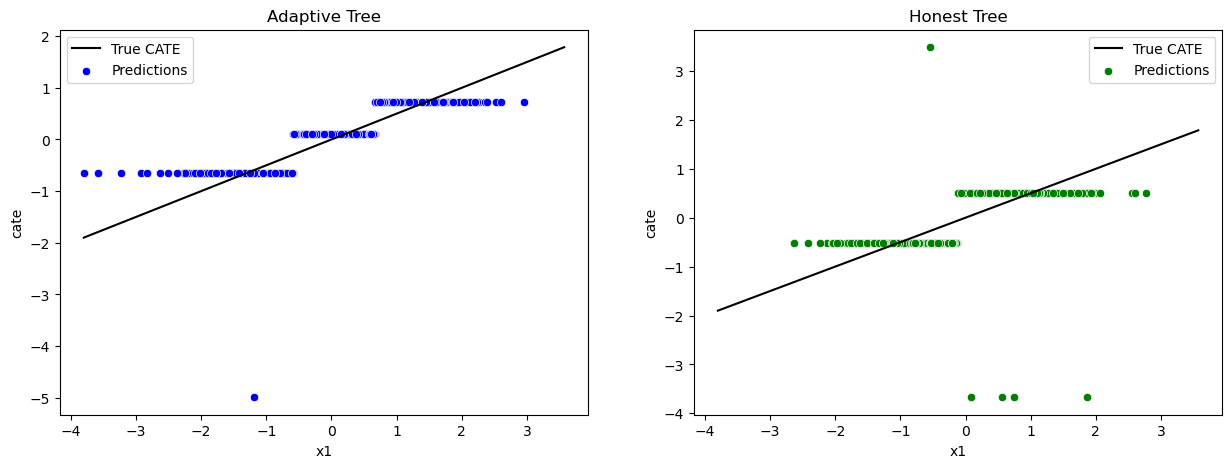

In [12]:
# plot predictions (CATEs) for both trees against true CATE = 0.5*x1
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='x1', y='cate', data=df, ax=ax[0], color = "black", label = "True CATE")
sns.scatterplot(x='x1', y='y_transformed_pred_adaptive', data=df.sample(1000), ax=ax[0], color='blue', label = "Predictions")
ax[0].set_title('Adaptive Tree')
sns.lineplot(x='x1', y='cate', data=df, ax=ax[1], color = "black", label = "True CATE")
sns.scatterplot(x='x1', y='y_transformed_pred_honest', data=df.sample(1000), ax=ax[1], color = "green", label = "Predictions")
ax[1].set_title('Honest Tree')
plt.show()

Since we have very simple trees here, we can plot the partition:

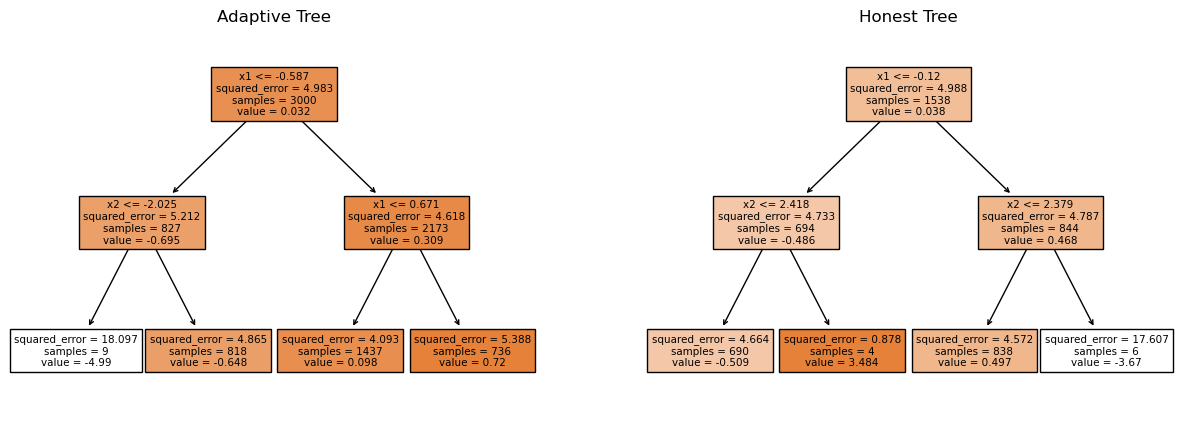

In [18]:
# plot both trees
from sklearn.tree import plot_tree

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_tree(A_tree, ax=ax[0], feature_names=['x1', 'x2'], filled=True)
ax[0].set_title('Adaptive Tree')
plot_tree(H_tree, ax=ax[1], feature_names=['x1', 'x2'], filled=True)
ax[1].set_title('Honest Tree')
plt.show()


### Evaluation

We saw that the transformed outcome was a noisy but unbiased estimate of the CATE. How well does the tree do in estimating it by taking leaf-wise averages?

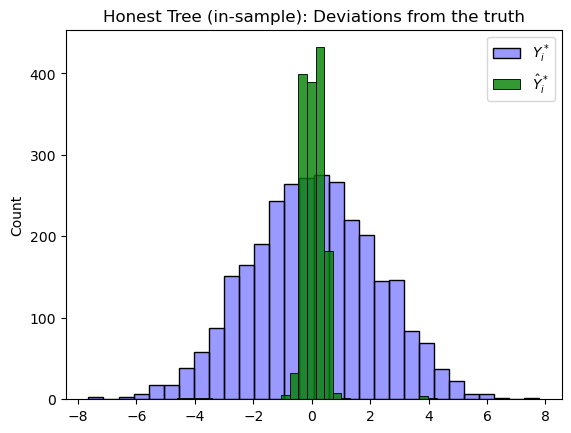

In [39]:
# Histogram of difference between true CATE and predictions for honest tree
sns.histplot(df['y_transformed'] - df['cate'], bins=30, color = "blue", alpha = 0.4, label = "$Y^*_i$")
sns.histplot(df['y_transformed_pred_honest'] - df['cate'], bins=30, color = "green", alpha = 0.8, label = "$\hat{Y}^*_i$")
plt.title('Honest Tree (in-sample): Deviations from the truth')
plt.legend()
plt.show()


Let's actually evaluate the MSE for treatment effects on a test set:
$$
MSE_\tau(S^{te}, S^{est}, \Pi(S^{tr}))^{\text{No correction}} = \frac{1}{\#(S^{te})} \sum_{i \in S^{te}} \left ((\tau_i - \hat{\tau}(X_i; S^{est}, \Pi))^2 \right )
$$

**Remarks**
- In the case of the adaptive tree, the estimation set is the same as the training set and replaced above.
- The criterion used for splitting in (honest) causal trees as suggested in PNAS takes the expectation (hence the expected MSE: "EMSE") over this quantity with regards to the test and estimation set (as both are random variables at the time of building the model structure given the training set). Here, these are already observed, so we can compute the MSE directly.

In [46]:
# simulate independent test set

df_test = simulate_exp1(1000, pr_w=0.5, var_eps=0.01) # same parameters as before
df_test.head()

,x1,x2,w,y,y_transformed,cate
0,-1.076015,-0.348514,1,-1.156734,-2.313468,-0.538007
1,1.133646,-0.673980,0,-0.395321,0.790643,0.566823
2,-1.155638,-1.673250,1,-2.570284,-5.140568,-0.577819
3,0.792450,2.092435,1,2.699763,5.399526,0.396225
4,-0.262288,0.301020,0,0.234601,-0.469203,-0.131144


In [47]:
from sklearn.metrics import mean_squared_error

# to get the estimate of tau for each observation in the test set, 
# we need to see in which leaf node it falls
df_test['leaf_adaptive'] = A_tree.apply(df_test[['x1', 'x2']])
df_test['leaf_honest'] = H_tree.apply(df_test[['x1', 'x2']])

# we also need to get the estimate of tau for each leaf node via the same method
df["leaf_adaptive"] = A_tree.apply(df[['x1', 'x2']])
df["leaf_honest"] = H_tree.apply(df[['x1', 'x2']])
# add estimate of tau (based on estimation set for honest tree, and whole training set for adaptive tree) to test set
df_test["tau_adaptive"] = df_test["leaf_adaptive"].map(df.groupby("leaf_adaptive")["y_transformed"].mean())
df_test["tau_honest"] = df_test["leaf_honest"].map(df.groupby("leaf_honest")["y_transformed"].mean())

df_test.head()

,x1,x2,w,y,y_transformed,cate,leaf_adaptive,leaf_honest,tau_adaptive,tau_honest
0,-1.076015,-0.348514,1,-1.156734,-2.313468,-0.538007,3,2,-0.647642,-0.466701
1,1.133646,-0.673980,0,-0.395321,0.790643,0.566823,6,5,0.719892,0.446107
2,-1.155638,-1.673250,1,-2.570284,-5.140568,-0.577819,3,2,-0.647642,-0.466701
3,0.792450,2.092435,1,2.699763,5.399526,0.396225,6,5,0.719892,0.446107
4,-0.262288,0.301020,0,0.234601,-0.469203,-0.131144,5,2,0.098374,-0.466701


We can now compute the infeasible MSE:

In [48]:
MSE_h = mean_squared_error(df_test['cate'], df_test['tau_honest'])
MSE_a = mean_squared_error(df_test['cate'], df_test['tau_adaptive'])

print('MSE for honest tree: ', MSE_h)
print('MSE for adaptive tree: ', MSE_a)


MSE for honest tree:  0.16707199045429252
MSE for adaptive tree:  0.11300007028911306


Let's run a small simulation study to see how this behaves over many different runs (of training, estimation and test sets):

In [49]:
# lets do 100 iterations:

MSE_h = []
MSE_a = []

for i in range(100):
    df = simulate_exp1(2000, pr_w=0.5, var_eps=0.01)
    A_tree = train_tree_A(df, min_samples_leaf=4)
    H_tree = train_tree_H(df, min_samples_leaf=4)
    df_test = simulate_exp1(1000, pr_w=0.5, var_eps=0.01)
    df_test['leaf_adaptive'] = A_tree.apply(df_test[['x1', 'x2']])
    df_test['leaf_honest'] = H_tree.apply(df_test[['x1', 'x2']])
    df["leaf_adaptive"] = A_tree.apply(df[['x1', 'x2']])
    df["leaf_honest"] = H_tree.apply(df[['x1', 'x2']])
    df_test["tau_adaptive"] = df_test["leaf_adaptive"].map(df.groupby("leaf_adaptive")["y_transformed"].mean())
    df_test["tau_honest"] = df_test["leaf_honest"].map(df.groupby("leaf_honest")["y_transformed"].mean())
    MSE_h.append(mean_squared_error(df_test['cate'], df_test['tau_honest']))
    MSE_a.append(mean_squared_error(df_test['cate'], df_test['tau_adaptive']))

{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 3}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 3}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 3}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 3}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 2}
{'max_depth': 

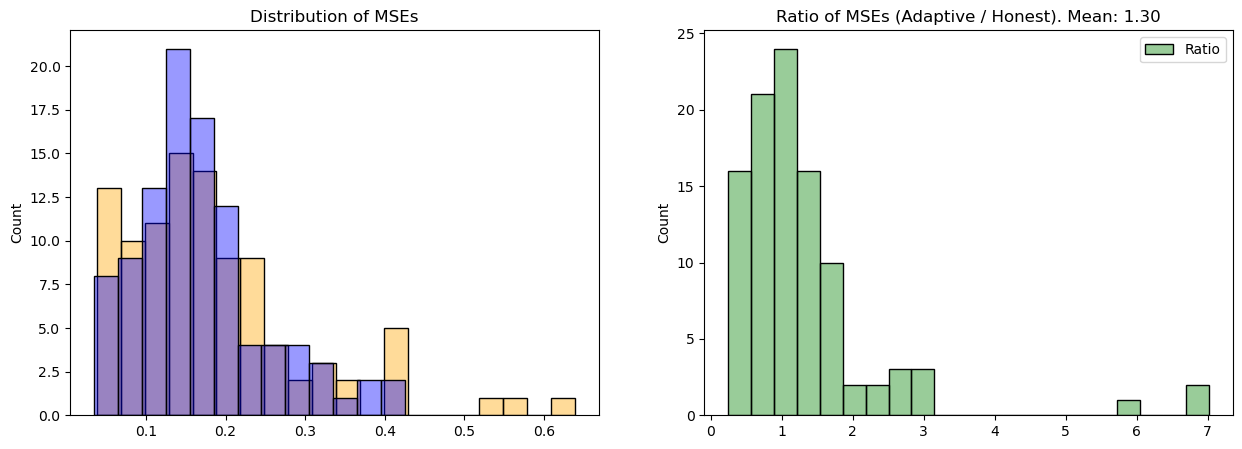

In [65]:
# plot distribution of MSEs in stacked histogram
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(MSE_a, binwidth=0.03, color="orange", alpha=0.4, label="Adaptive Tree", ax=ax[0])
sns.histplot(MSE_h, binwidth=0.03, color="blue", alpha=0.4, label="Honest Tree", ax=ax[0])

# calculate the division of the two lists element-wise
ratio = [a / h for a, h in zip(MSE_a, MSE_h)]
sns.histplot(ratio, color="green", alpha=0.4, label="Ratio", ax=ax[1])

ax[0].set_title("Distribution of MSEs")
ax[1].set_title("Ratio of MSEs (Adaptive / Honest). Mean: {:.2f}".format(np.mean(ratio)))

plt.legend()
plt.show()

The honest tree seems a little more stable - but one would have to run a lot more iterations and perhaps larger samples to be sure.
In the simulation of Athey & Wager the ratio of the infeasible MSE (TOT-A/TOT-H) was just barely above 1 with 1.021 (in a simulation that was slightly larger but of same dimension).

## Using SHAP values to explain hetergeneous treatment effects

In my view there are two ways for shap values to be potentially interesting here:
1. Use shap on the CATE predictions:
   Similar to how black-box predictive machine learning models can be explained with SHAP, we can also explain black-box effect heterogeneity models. This approach provides an explanation as to why a heterogeneous causal effect model produced larger or smaller effect values for particular segments of the population. 
   Via **interventional** shap values, we might be able to back out that the CATE only depends on $x_1$ wth some level of confidence?
2. Use shap values to explain the MSE in the leaves of the tree: 
   In other words, do a the variance decomposition of the measure that is also used as a splitting criterion. We want to understand which covariates define relevant subgroups for which treatment heterogeneity is much greater than others.

The first is simply implemented and immediately doable. It also integrates nicely with the existing library for growing causal trees `econml` by Microsoft.

The second requires a rewriting of existing shap computing programmes to compute a loss measure.

In general, the approach of using SHAP values only becomes insightful when moving to more complex ensembles of trees, when we can no longer inspect the partition directly. Nevertheless it is fruitful to discuss and judge the usefulness of these ideas on the more simple single tree models.

### 1. Using shap on the CATE predictions

**Applications**
- Potential for better targeting of treatment: Identification of subgroups with especially high or low treatment effects
- Potential for understanding which covariates drive treatment effect model $\kappa(x)$
without having to rely on (problematic) subgroup analysis or making sparsity assumptions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


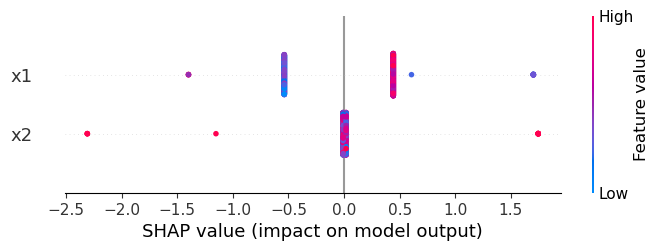

In [27]:
import shap

# shap explain the predictions of the TOT
explainer = shap.TreeExplainer(H_tree)
shap_values = explainer(df_test[['x1', 'x2']])
shap.plots.beeswarm(shap_values)

Based on this we can be *pretty sure* that $\kappa(x)$ is only a function of $x_1$. Here we do not have to bother specifying a dependency structure to the explanation object since features were simulated under independence. The sparsity of the explanation, i.e. the fact that we only see two vertical lines on the shap spectrum, is because there are only 2 leaf nodes with significant number of samples in them.

### 2. Using shap to explain the MSE in the leaves of the tree

**Idea**

We would like to do a variance decomposition of the treatment heterogeneity among covariates.

Recall that we built a partition that seeks to minimize the (expected) MSE of the treatment effect. We can now use shap values to explain the MSE in the leaves of the tree. This would give us the contribution of each covariate to the variation, and hence the heterogeneity, of the treatment effect in each leaf node.

These explanation values would satisfy the Shapley desiderata, since using the treeSHAP algorithm allows to compute exact SHAP values in polynomial time and memory.

**Challenge**

Computing a custom "loss" of a model, be it a TOT or a causally grown tree, is not available off-the-shelf in the shap package. 
To let the value of the game equal the MSE of the leaf node, means that the contribution of a coalition of features for a particular observation, unlike for standard output explanations, is not only dependent on the covariates $X_i$ but also on the observed outcome $Y_i$ (and the treatment status $W_i$, in causal trees), since all of these are components of the MSE.

These are all observed quantities, which means that this is not a conceptual problem, but rather a matter of coding it up.